### Conversão para PNG

In [258]:
import sys
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

ROOT_DIR = Path.cwd().parent
sys.path.append(str(ROOT_DIR))
LOCCA_DIR = ROOT_DIR / 'datasets/locca'

from src.utils.load_image_and_annotation import load_nifti, load_nrrd, visualize_slice  # noqa: E402, F401

In [243]:
def vols_generator(volumes_paths, masks_paths):
    for vol_path, mask_path in zip(volumes_paths, masks_paths):
        yield load_nifti(vol_path)[0], load_nrrd(mask_path)[0], vol_path

In [244]:
volumes = sorted(LOCCA_DIR.glob('images*/*/*.nii.gz'), key=lambda p:p.name)
masks_paths = sorted(LOCCA_DIR.glob('annotations*/*.nrrd'), key=lambda p:p.name)

data_generator = vols_generator(volumes, masks_paths)

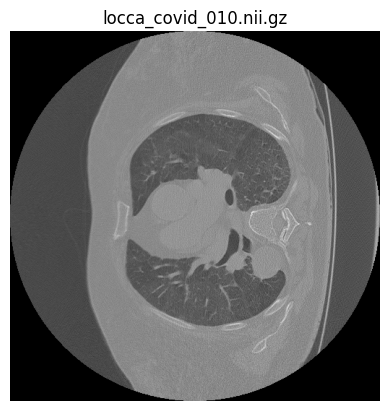

In [211]:
idx = random.randint(0, 59)
sample_file = volumes[idx]
sample_mask = masks_paths[idx]
vol, _ = load_nifti(str(sample_file))
masks, _ = load_nrrd(str(sample_mask))

jdx = random.randint(0, vol.shape[-1]-1)
slice = vol[:, :, jdx]
mask = masks[:, :, jdx]
plt.imshow(slice, cmap='gray'); plt.axis('off'); plt.title(sample_file.name); plt.show()

In [212]:
# Janelamento na slice de amostra
new_slice = np.clip(slice, -1000, 650)
new_slice = (new_slice - (-1000)) / (650 - (-1000))
new_slice = (new_slice*255).astype(np.uint8)
# slice = (image - min_val) / (max_val - min_val)

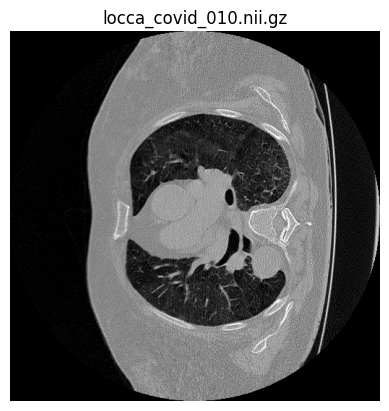

In [213]:
plt.imshow(new_slice, cmap='gray'); plt.axis('off'); plt.title(sample_file.name); plt.show()

In [148]:
np.unique(mask)

array([0, 1, 2, 3, 4, 5], dtype=uint16)

In [116]:
# import cv2


# clahe = cv2.createCLAHE(clipLimit=1)
# clahe_img = np.clip(clahe.apply(new_slice) + 15, 0, 255).astype(np.uint8)
# _, threshold_img = cv2.threshold(new_slice, 155, 255, cv2.THRESH_BINARY)

# plt.imshow(clahe_img, cmap='gray')

In [215]:
def pre_processar(ct_slice: np.array, mask: np.array):
    # Windowing
    new_slice = np.clip(ct_slice, -1000, 650)
    new_slice = (new_slice + 1000) / 1650
    new_slice = (new_slice*255).astype(np.uint8)

    # Divisão dos pulmões
    mask = mask.astype(np.uint8)
    right_lung = np.isin(mask, [1,2]).astype(np.uint8)
    left_lung = np.isin(mask, [3,4,5]).astype(np.uint8)

    return new_slice, mask, right_lung, left_lung

#### Loop de Conversão

In [259]:
import cv2

OUTUP_DIR = LOCCA_DIR / 'pngs_preprocessed'
IMAGES_DIR = OUTUP_DIR / 'images'
MASKS_DIR = OUTUP_DIR / 'masks'

OUTUP_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)
MASKS_DIR.mkdir(exist_ok=True)

In [ ]:
cont = 0
for vol, masks, vol_path in tqdm(data_generator, total=60):
    assert vol.shape == masks.shape, "Volume e máscara com shapes diferentes"
    num_slices = vol.shape[-1]

    # if cont>= 5:
    #     break

    base_filename = vol_path.name.split('.')[0]


    for i in range(num_slices):
        ct_slice, mask, right_lung, left_lung = pre_processar(vol[:, :, i], masks[:, :, i])

        cv2.imwrite(
            str(IMAGES_DIR/f'{base_filename}_{i}.png'), 
            ct_slice 
        )

        cv2.imwrite(
            str(MASKS_DIR/f'{base_filename}_{i}.png'), 
            mask 
        )

        cv2.imwrite(
            str(MASKS_DIR/f'rl_{base_filename}_{i}.png'), 
            right_lung 
        )

        cv2.imwrite(
            str(MASKS_DIR/f'll_{base_filename}_{i}.png'), 
            left_lung
        )
    
    cont +=1

  0%|          | 0/60 [00:00<?, ?it/s]

In [255]:
mask = cv2.imread('../datasets/locca/pngs_preprocessed/masks/locca_covid_001_200.png', 0)

In [256]:
np.unique(mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

### Divisão treino/teste

In [289]:
import shutil
from typing import List
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split


X = sorted(OUTUP_DIR.glob('images/*.png'))
y = sorted(OUTUP_DIR.glob('masks/locca*.png')) + sorted(OUTUP_DIR.glob('masks/lung*.png'))


In [290]:
for i, j in zip(X,y):
    if i.name != j.name:
        print('Erro na listagem de caminhos!')
        print(i)
        break

In [291]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42
)

In [292]:
def copy_files(paths: List[Path], storer_dir: Path):
    if not storer_dir.exists():
        storer_dir.mkdir(parents=True, exist_ok=True)

    for path in tqdm(paths):
        shutil.copy(path, storer_dir)



copy_files(X_train, OUTUP_DIR/'train/images')
copy_files(X_test, OUTUP_DIR/'test/images')
copy_files(y_train, OUTUP_DIR/'train/masks')
copy_files(y_test, OUTUP_DIR/'test/masks')

  0%|          | 0/17746 [00:00<?, ?it/s]

  0%|          | 0/4437 [00:00<?, ?it/s]

  0%|          | 0/17746 [00:00<?, ?it/s]

  0%|          | 0/4437 [00:00<?, ?it/s]